# Analyse Avancée des Anomalies Climatiques
Ce notebook présente une analyse complète des données traitées par le pipeline Big Data (Bronze/Silver/Gold).
Les visualisations sont regroupées en 5 catégories :
1. Vue d’ensemble des données
2. Tendances temporelles
3. Z-score & événements extrêmes
4. Visualisations géographiques
5. Qualité des données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# Configuration graphique
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Fonction utilitaire pour lire les CSV issus de Spark (partitionnés)
def read_spark_csv(folder_path):
    all_files = glob.glob(os.path.join(folder_path, "part-*.csv"))
    if not all_files:
        print(f"Warning: No CSV files found in {folder_path}")
        return pd.DataFrame()
    return pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# Chemins des données (Volume Docker monté)
BASE_DIR = "/opt/spark/data/Power bi"


## Chargement des Données
Chargement des 4 tables finales produites par la couche Gold.

In [2]:
print("Chargement des datasets...")
df_anomalies = read_spark_csv(os.path.join(BASE_DIR, "climate_anomalies_monthly.csv"))
df_kpis = read_spark_csv(os.path.join(BASE_DIR, "climate_kpis.csv"))
df_extremes = read_spark_csv(os.path.join(BASE_DIR, "climate_extremes.csv"))
df_stations = read_spark_csv(os.path.join(BASE_DIR, "stations_dim.csv"))

# Conversion des dates
if not df_anomalies.empty:
    df_anomalies['date'] = pd.to_datetime(df_anomalies['date'])
    df_anomalies['year'] = df_anomalies['year'].astype(int)
    df_anomalies['month'] = df_anomalies['month'].astype(int)

if not df_extremes.empty:
    df_extremes['date'] = pd.to_datetime(df_extremes['date'])
    df_extremes['year'] = df_extremes['date'].dt.year

print("Datasets chargés :")
print(f"- Anomalies: {df_anomalies.shape}")
print(f"- KPIs: {df_kpis.shape}")
print(f"- Extremes: {df_extremes.shape}")
print(f"- Stations: {df_stations.shape}")

Chargement des datasets...
Datasets chargés :
- Anomalies: (412400, 12)
- KPIs: (143, 6)
- Extremes: (31784, 7)
- Stations: (129658, 6)


## 1. Vue d’ensemble des données

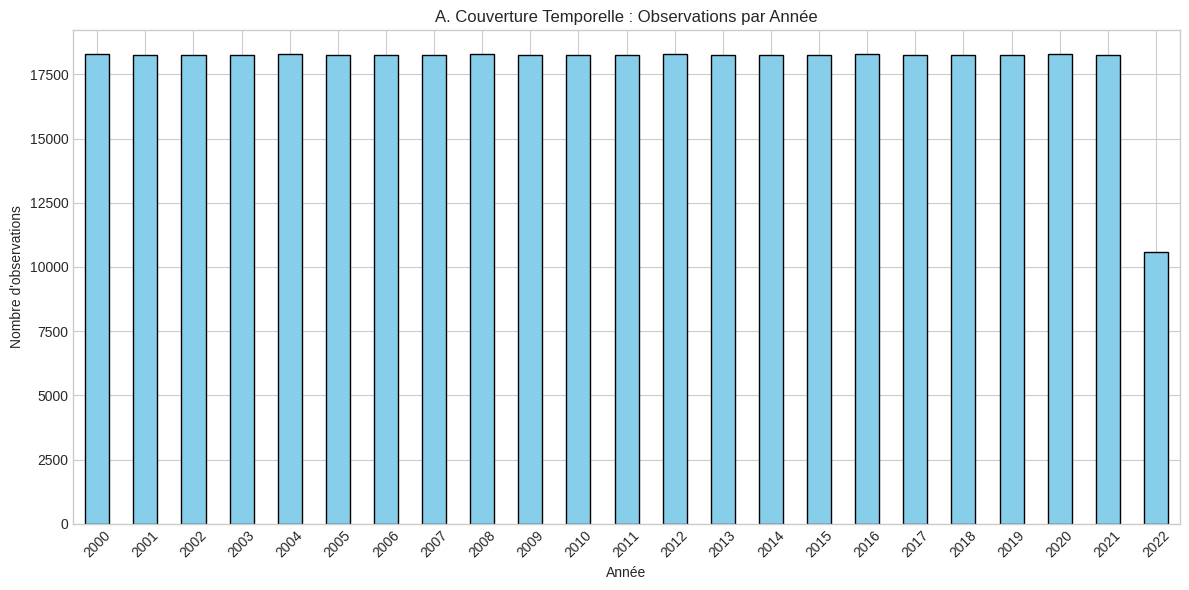

In [3]:
# A. Bar chart — Nombre d’observations par année
if not df_anomalies.empty:
    obs_by_year = df_anomalies['year'].value_counts().sort_index()
    plt.figure()
    obs_by_year.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('A. Couverture Temporelle : Observations par Année')
    plt.xlabel('Année')
    plt.ylabel('Nombre d\'observations')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

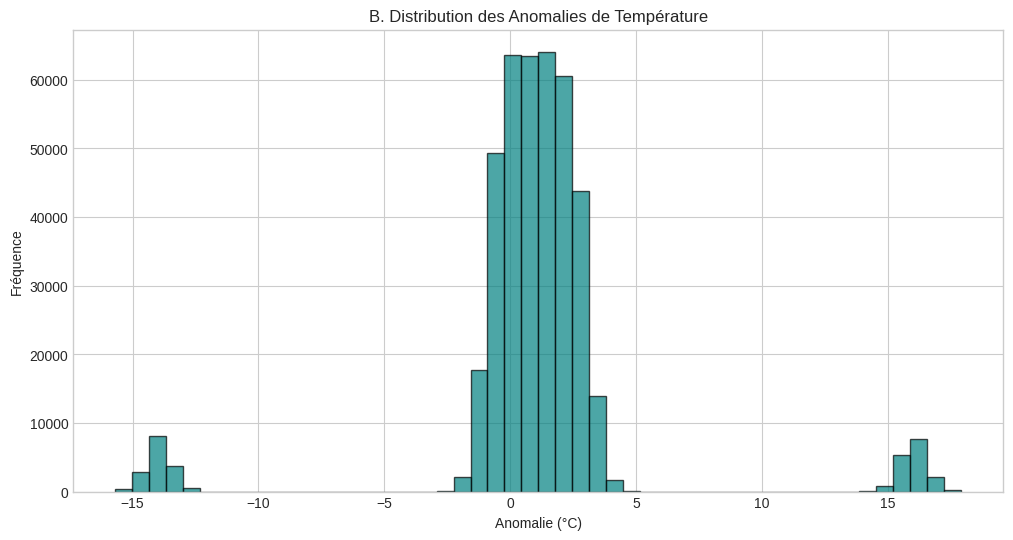

In [4]:
# B. Histogram — Distribution des anomalies
if not df_anomalies.empty:
    plt.figure()
    df_anomalies['temperature_anomaly'].hist(bins=50, color='teal', alpha=0.7, edgecolor='black')
    plt.title('B. Distribution des Anomalies de Température')
    plt.xlabel('Anomalie (°C)')
    plt.ylabel('Fréquence')
    plt.show()

<Figure size 1200x600 with 0 Axes>

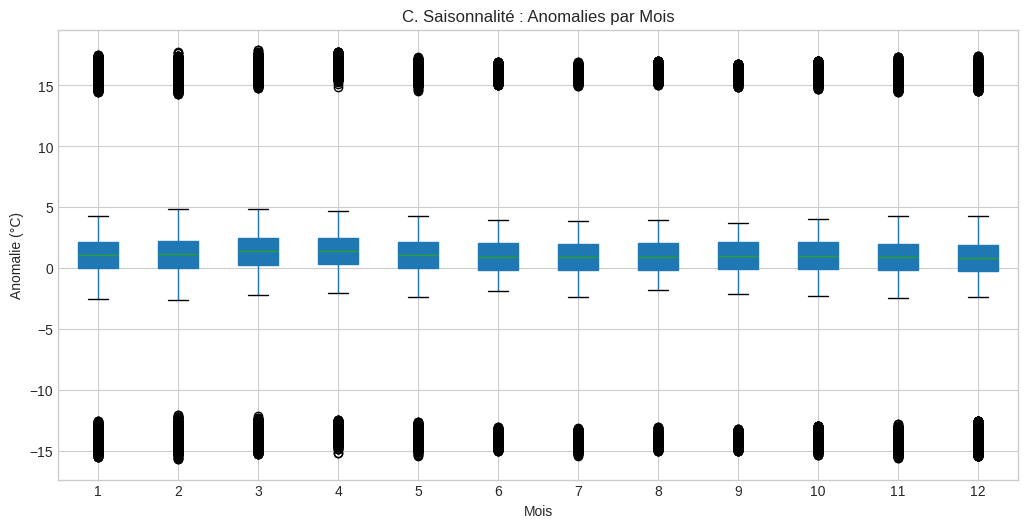

In [5]:
# C. Boxplot — Anomalies par mois
if not df_anomalies.empty:
    plt.figure()
    df_anomalies.boxplot(column='temperature_anomaly', by='month', grid=True, patch_artist=True)
    plt.title('C. Saisonnalité : Anomalies par Mois')
    plt.suptitle('') # Supprime le titre par défaut de pandas
    plt.xlabel('Mois')
    plt.ylabel('Anomalie (°C)')
    plt.show()

## 2. Tendances Temporelles

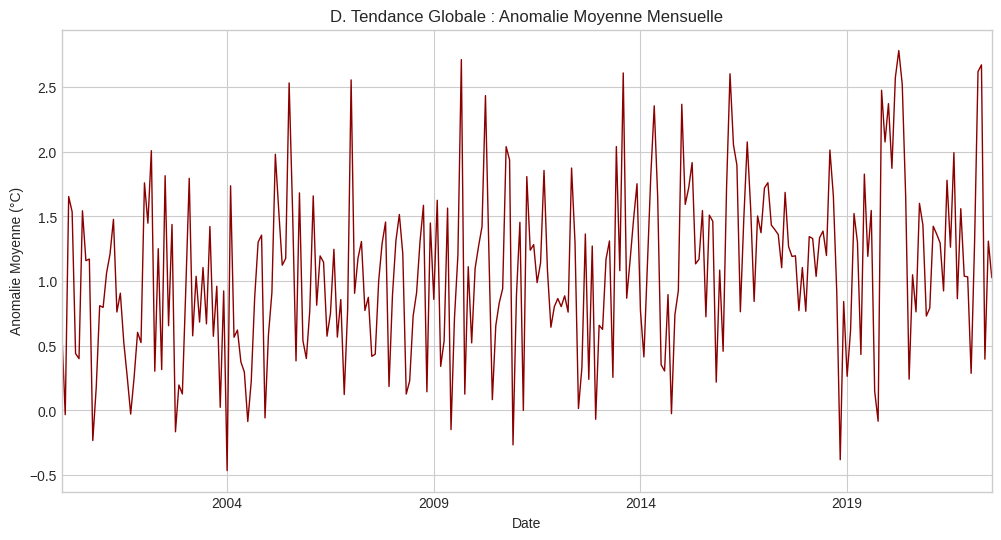

In [6]:
# D. Line chart — Anomalie moyenne globale par mois
if not df_anomalies.empty:
    monthly_global = df_anomalies.groupby('date')['temperature_anomaly'].mean()
    plt.figure()
    monthly_global.plot(color='darkred', lw=1)
    plt.title('D. Tendance Globale : Anomalie Moyenne Mensuelle')
    plt.ylabel('Anomalie Moyenne (°C)')
    plt.xlabel('Date')
    plt.show()

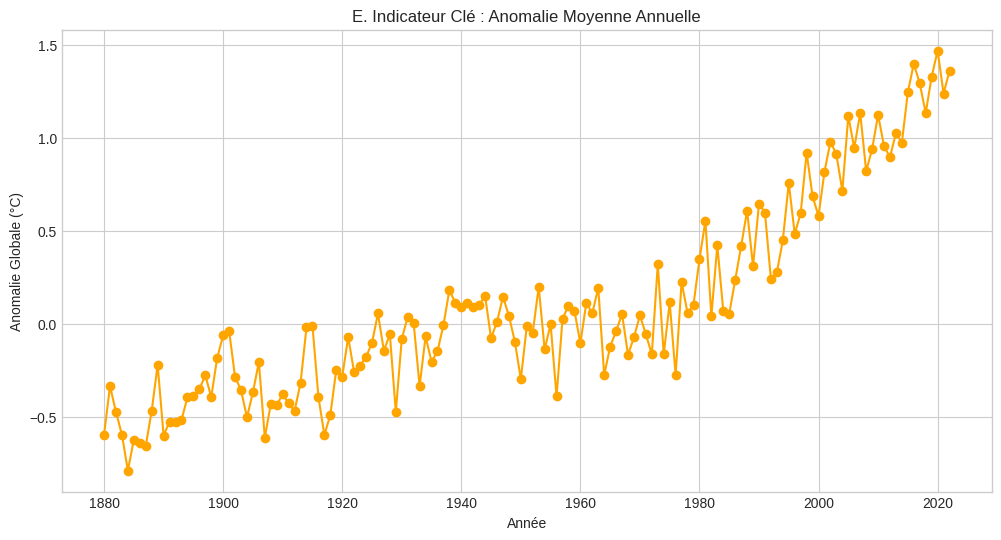

In [7]:
# E. Line chart — KPI annuel (Avg Global Anomaly)
if not df_kpis.empty:
    df_kpis_sorted = df_kpis.sort_values('year')
    plt.figure()
    plt.plot(df_kpis_sorted['year'], df_kpis_sorted['avg_global_anomaly'], marker='o', linestyle='-', color='orange')
    plt.title('E. Indicateur Clé : Anomalie Moyenne Annuelle')
    plt.xlabel('Année')
    plt.ylabel('Anomalie Globale (°C)')
    plt.grid(True)
    plt.show()

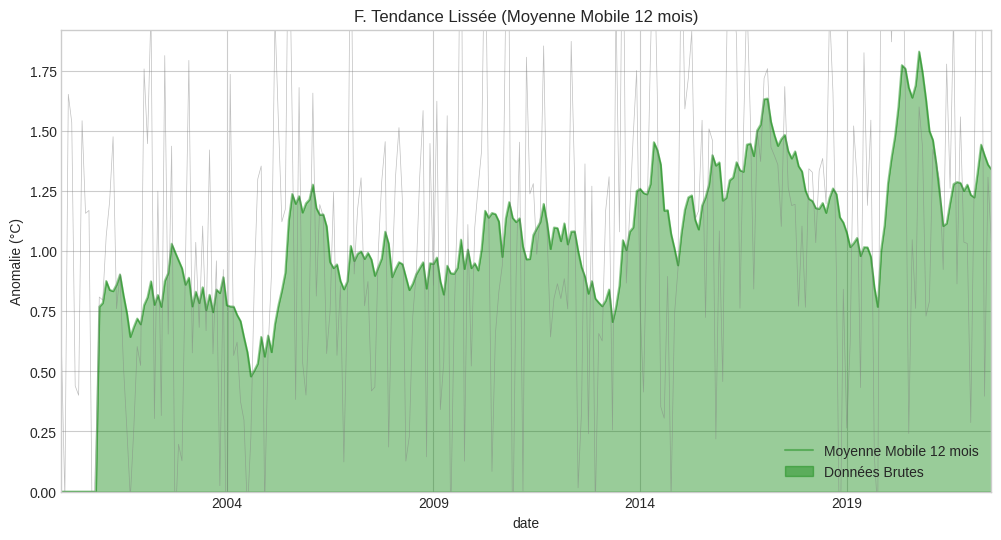

In [8]:
# F. Area chart — Moyenne mobile 12 mois
if not df_anomalies.empty:
    monthly_global = df_anomalies.groupby('date')['temperature_anomaly'].mean()
    rolling_mean = monthly_global.rolling(window=12).mean()
    
    plt.figure()
    rolling_mean.plot(kind='area', alpha=0.4, color='green')
    monthly_global.plot(lw=0.5, color='gray', alpha=0.5, label='Mensuel')
    plt.title('F. Tendance Lissée (Moyenne Mobile 12 mois)')
    plt.ylabel('Anomalie (°C)')
    plt.legend(['Moyenne Mobile 12 mois', 'Données Brutes'])
    plt.show()

## 3. Z-score & Événements Extrêmes

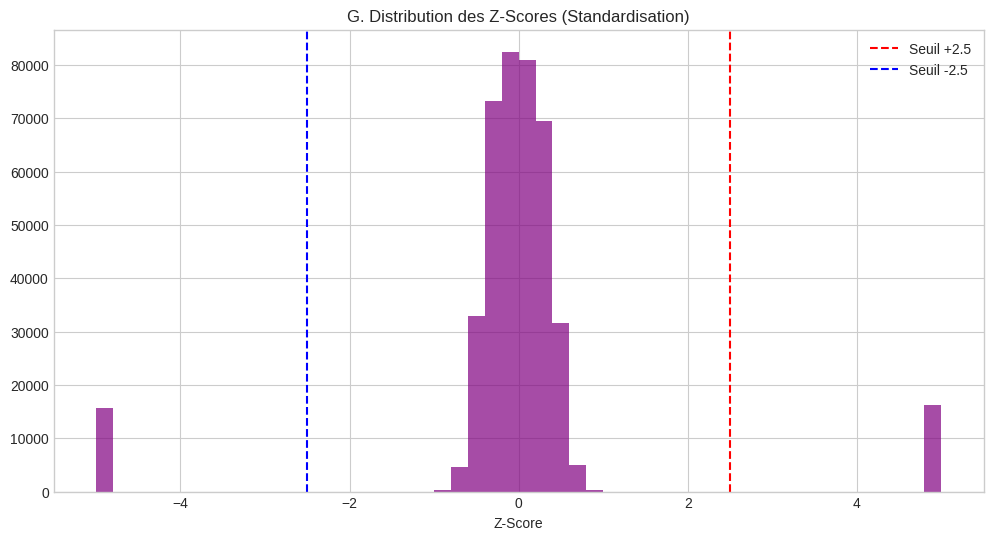

In [9]:
# G. Histogram — Distribution des Z-scores
if not df_anomalies.empty:
    plt.figure()
    df_anomalies['z_score'].hist(bins=50, color='purple', alpha=0.7)
    plt.axvline(2.5, color='red', linestyle='--', label='Seuil +2.5')
    plt.axvline(-2.5, color='blue', linestyle='--', label='Seuil -2.5')
    plt.title('G. Distribution des Z-Scores (Standardisation)')
    plt.xlabel('Z-Score')
    plt.legend()
    plt.show()

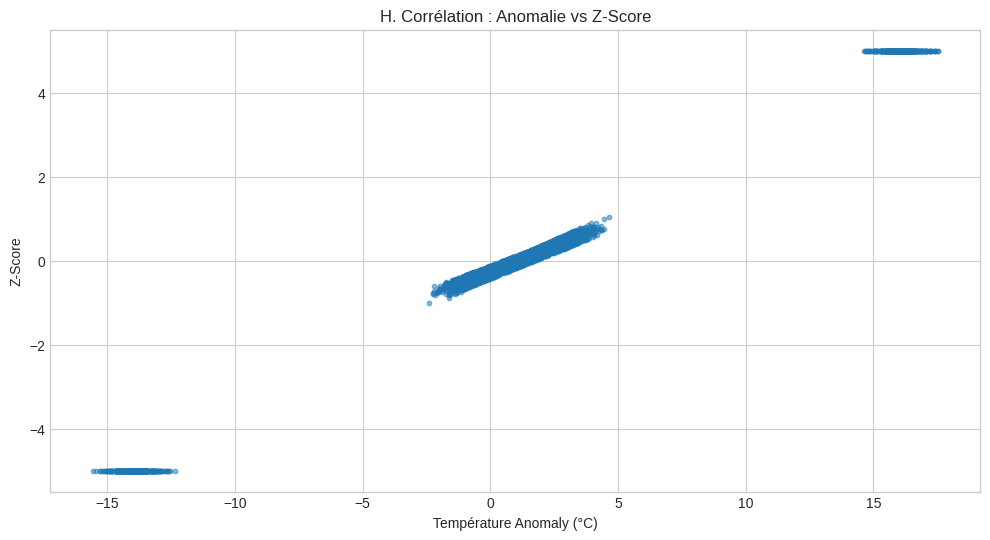

In [10]:
# H. Scatter plot — Anomaly vs Z-score
if not df_anomalies.empty:
    plt.figure()
    # Sample pour lisibilité si trop de données
    data_sample = df_anomalies.sample(min(10000, len(df_anomalies)))
    plt.scatter(data_sample['temperature_anomaly'], data_sample['z_score'], alpha=0.5, s=10)
    plt.title('H. Corrélation : Anomalie vs Z-Score')
    plt.xlabel('Température Anomaly (°C)')
    plt.ylabel('Z-Score')
    plt.grid(True)
    plt.show()

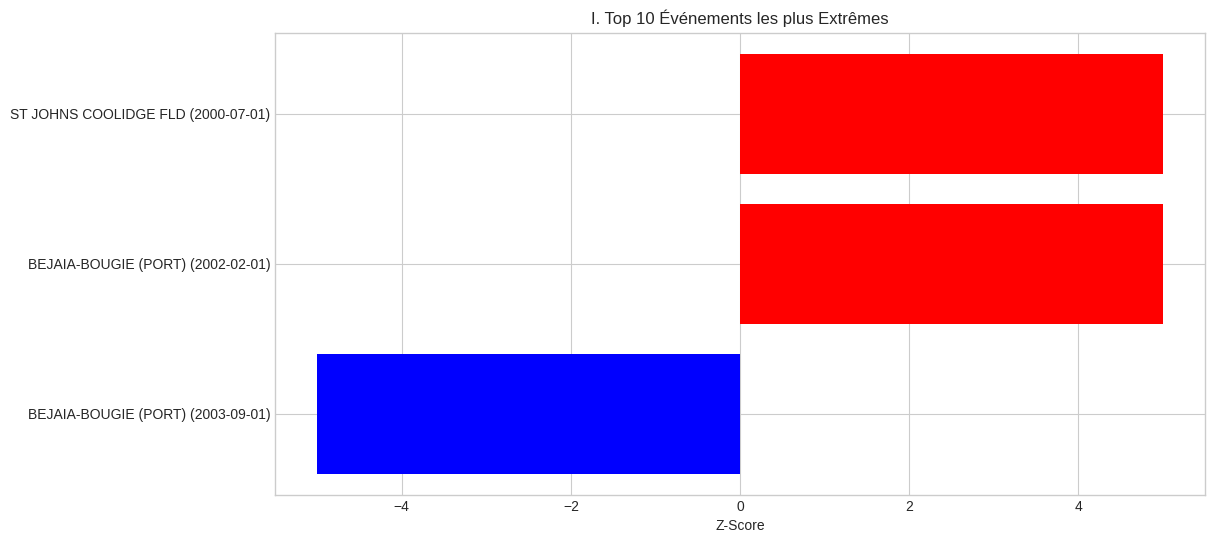

In [11]:
# I. Bar chart — Top 10 Événements Extrêmes (Abs Z-Score)
if not df_extremes.empty:
    top_10 = df_extremes.reindex(df_extremes['z_score'].abs().sort_values(ascending=False).index).head(10)
    
    plt.figure()
    colors = np.where(top_10['event_type']=='EXTREME_HEAT', 'red', 'blue')
    plt.barh(top_10['location'] + ' (' + top_10['date'].astype(str) + ')', top_10['z_score'], color=colors)
    plt.title('I. Top 10 Événements les plus Extrêmes')
    plt.xlabel('Z-Score')
    plt.gca().invert_yaxis()
    plt.show()

<Figure size 1200x600 with 0 Axes>

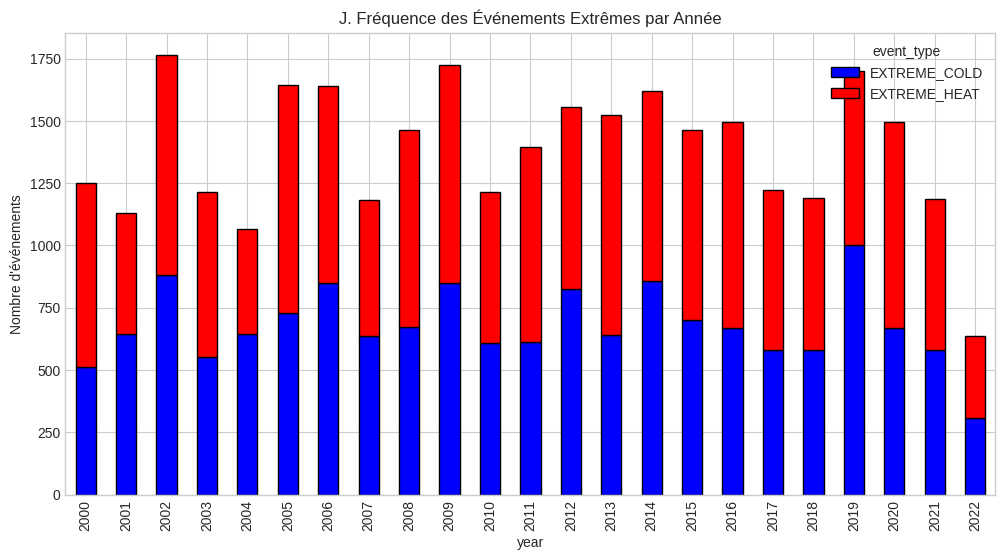

In [12]:
# J. Stacked Bar — Nb d’événements extrêmes par année
if not df_extremes.empty:
    pivot_events = df_extremes.pivot_table(index='year', columns='event_type', values='station_id', aggfunc='count', fill_value=0)
    
    plt.figure()
    pivot_events.plot(kind='bar', stacked=True, color=['blue', 'red'], edgecolor='black')
    plt.title('J. Fréquence des Événements Extrêmes par Année')
    plt.ylabel('Nombre d\'événements')
    plt.show()

## 4. Visualisations Géographiques

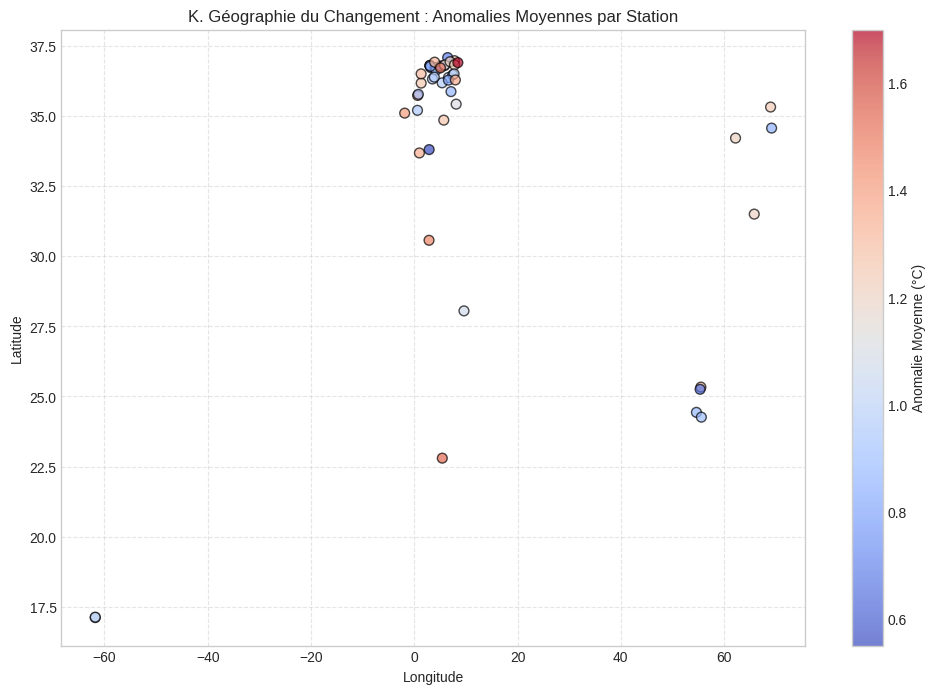

In [13]:
# Préparation : Jointure avec Stations
if not df_anomalies.empty and not df_stations.empty:
    # Moyenne des anomalies par station
    station_stats = df_anomalies.groupby('station_id')['temperature_anomaly'].mean().reset_index()
    geo_data = pd.merge(station_stats, df_stations, on='station_id')

    # K. Scatter map — Anomalies Moyennes
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(geo_data['longitude'], geo_data['latitude'], 
                          c=geo_data['temperature_anomaly'], cmap='coolwarm', 
                          s=50, alpha=0.7, edgecolor='k')
    plt.colorbar(scatter, label='Anomalie Moyenne (°C)')
    plt.title('K. Géographie du Changement : Anomalies Moyennes par Station')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

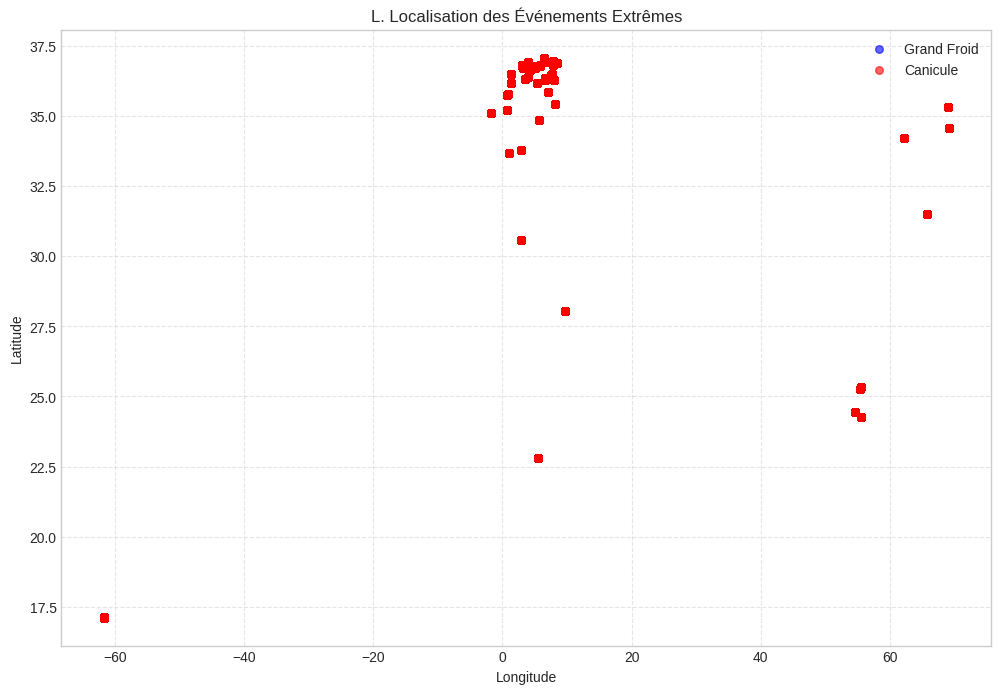

In [14]:
# L. Scatter map — Événements Extrêmes
if not df_extremes.empty and not df_stations.empty:
    # On prend les coordonnées depuis stations_dim
    geo_extremes = pd.merge(df_extremes, df_stations[['station_id', 'latitude', 'longitude']], on='station_id', how='left')
    
    plt.figure(figsize=(12, 8))
    # Séparer Heat et Cold pour les couleurs
    heat = geo_extremes[geo_extremes['event_type'] == 'EXTREME_HEAT']
    cold = geo_extremes[geo_extremes['event_type'] == 'EXTREME_COLD']
    
    plt.scatter(cold['longitude'], cold['latitude'], c='blue', s=30, label='Grand Froid', alpha=0.6)
    plt.scatter(heat['longitude'], heat['latitude'], c='red', s=30, label='Canicule', alpha=0.6)
    
    plt.title('L. Localisation des Événements Extrêmes')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

## 5. Qualité des Données

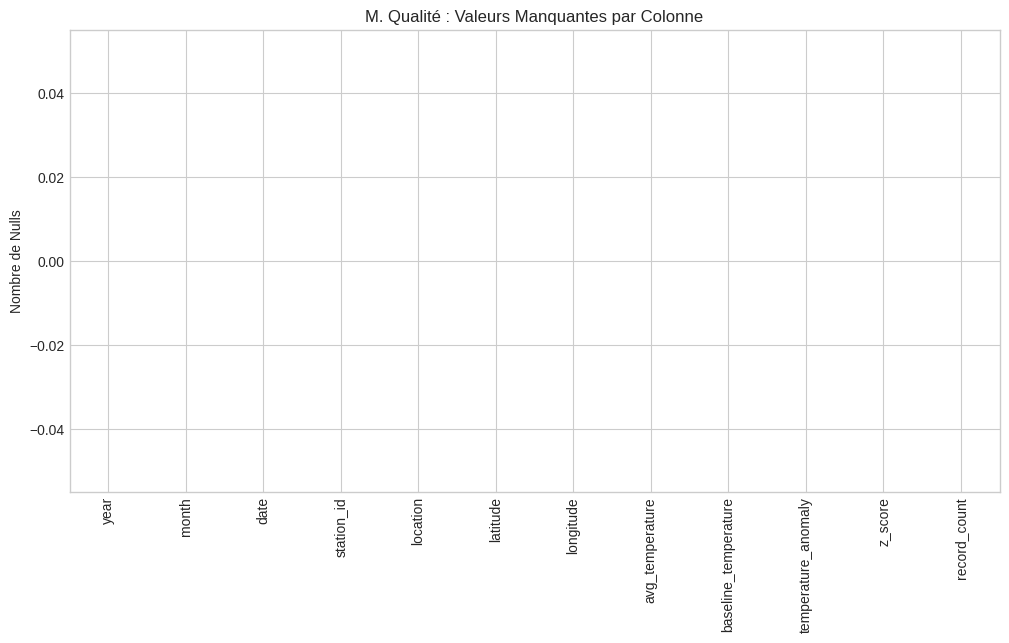

In [15]:
# M. Valeurs manquantes
if not df_anomalies.empty:
    null_counts = df_anomalies.isnull().sum()
    plt.figure()
    null_counts.plot(kind='bar', color='gray')
    plt.title('M. Qualité : Valeurs Manquantes par Colonne')
    plt.ylabel('Nombre de Nulls')
    plt.show()

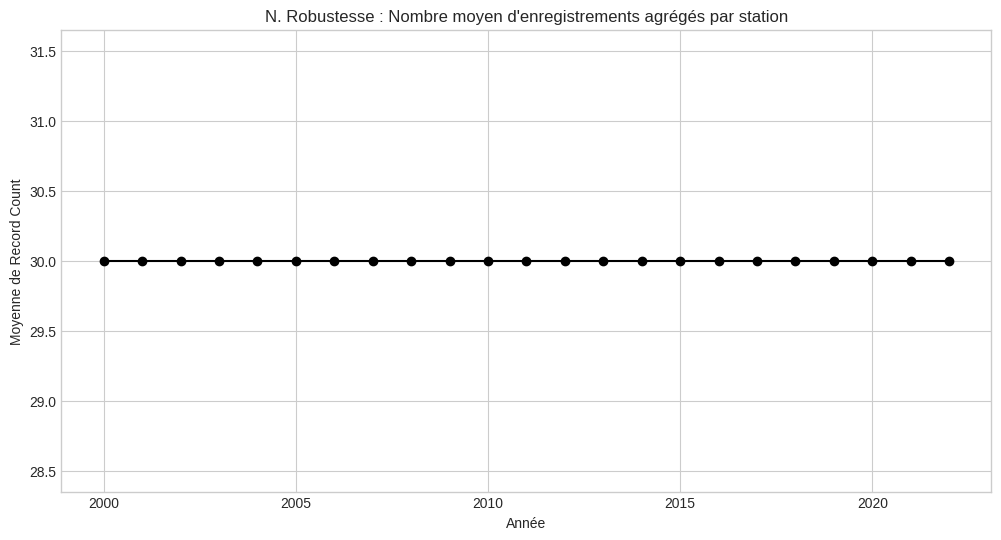

In [16]:
# N. Record Count Moyen par Année
if not df_anomalies.empty:
    avg_records = df_anomalies.groupby('year')['record_count'].mean()
    plt.figure()
    avg_records.plot(kind='line', marker='o', color='black')
    plt.title('N. Robustesse : Nombre moyen d\'enregistrements agrégés par station')
    plt.ylabel('Moyenne de Record Count')
    plt.xlabel('Année')
    plt.show()